In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import joblib
import numpy as np
import pandas as pd
import shap

# Import model

In [2]:
clf = joblib.load("dropout_prediction/models/trained_models/GB2_full_training.pkl")

Trying to unpickle estimator _BinMapper from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator HistGradientBoostingClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [3]:
clf

HistGradientBoostingClassifier(learning_rate=0.05, max_depth=22)

# Get dataset

In [4]:
from datetime import datetime
def week2datetime(n):
    s = str(n)
    if len(s)==1:
        s = "0" + s
    if n>20: 
        return datetime.strptime(f"1-{s}/2021", "%w-%W/%Y")
    elif n<=20:
        return datetime.strptime(f"1-{s}/2022", "%w-%W/%Y")

week2datetime(25).strftime("%d/%m/%Y")

'21/06/2021'

In [5]:
from dropout_prediction.models.model_training import ModelFactory

my_optimizer = ModelFactory({"name": "evaluation"})
my_optimizer.load_data("features.csv")

data = my_optimizer.features
data["logits"] = clf.predict_proba(data )[:, 1] # dropout risk
data['labels'] = my_optimizer.labels
data['group'] = my_optimizer.groups
data['Dato'] = data['week'].apply(week2datetime)
train_ids, test_ids = my_optimizer._grouped_test_train_split()
data_train = data.iloc[train_ids].reset_index(drop = True)
data_test = data.iloc[test_ids].reset_index(drop = True)


Instantiated ModelFactory with the following parameters:
{'name': 'evaluation'}


In [6]:
data_test

address_changes  internship_cancelled  days_since_last_evaluation  \
0                     0                     0                        38.0   
1                     0                     1                        30.0   
2                     0                     0                        37.0   
3                     0                     0                        31.0   
4                     0                     0                        40.0   
...                 ...                   ...                         ...   
158774                0                     0                        48.0   
158775                0                     1                        70.0   
158776                0                     0                      -100.0   
158777                0                     1                        94.0   
158778                1                     0                        28.0   

        number_of_evaluations  days_since_edu_start  days_to_edu_end  \
0                           0                   181           1064.0   
1                           0                   181           1064.0   
2                           0                   181            183.0   
3                           0                   181           1064.0   
4                           0                   181           1064.0   
...                       ...                   ...              ...   
158774                      0                   152           1096.0   
158775                      0                   364           1096.0   
158776                      0                    -1           1246.0   
158777                      0                   364            881.0   
158778                      1                   154            365.0   

        distance_to_ucl_campus  number_of_sessions  number_of_active_days  \
0                   104.466488                   0                      0   
1                     0.000000                   0                      0   
2                     3.734639                   0                      0   
3                     3.734639                   0                      0   
4                    44.774625                   0                      0   
...                        ...                 ...                    ...   
158774                6.651310                  39                     17   
158775                3.734639                   0                      0   
158776                3.734639                   6                      3   
158777                0.000000                  57                     26   
158778              238.227858                   0                      0   

        avg_daily_session_duration  ...  latest_grade_Failed  \
0                         0.000000  ...                    0   
1                         0.000000  ...                    0   
2                         0.000000  ...                    0   
3                         0.000000  ...                    0   
4                         0.000000  ...                    0   
...                            ...  ...                  ...   
158774                 2605.355392  ...                    0   
158775                    0.000000  ...                    1   
158776                  283.833333  ...                    0   
158777                 6281.794872  ...                    0   
158778                    0.000000  ...                    0   

        latest_grade_Not submitted  latest_grade_Passed  latest_grade_Sick  \
0                                0                    0                  0   
1                                0                    0                  0   
2                                0                    0                  0   
3                                0                    1                  0   
4                                0                    0                  0   
...                            ...                  ... 

# Hvordan ser en studerendes risikoprofil ud?

In [7]:
def make_risk_profile_fig(group_ids, data):
    """Plot risk profile of students in group_ids."""
    fig = px.line(data_test.set_index("group").loc[group_ids].sort_values(by=["Dato","days_since_edu_start" ]).reset_index(),
        x="Dato",
        y = "logits", 
        color = "group", 
        title = "Udvikling i frafaldssandsynlighed over tid", 
        labels=dict(logits="Frafaldssandsynlighed")
     )
    fig.layout.yaxis.tickformat = ',.0%'
    return fig

In [8]:
import plotly_express as px
np.random.seed(4)

N = 3
studerende_sample = np.random.choice(data_test[data_test["labels"]==1 ]['group'].unique(),size = N, replace = False)
print(studerende_sample)

fig = make_risk_profile_fig(studerende_sample, data_test)
fig.show()

['A073AC64-745E-EC11-A304-005056B2D348'
 '84ED1781-D9F9-EB11-A2DB-005056B2F3EA'
 '68441965-B86D-EB11-A2FA-005056B24458']


# Hvordan kan vi forstå modellens forudsigelse?

In [9]:
from matplotlib import pylab as plt
import shap  # package used to calculate Shap values

# load JS visualization code to notebook
shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(data_test.iloc[:,:-4])


In [10]:
def get_edge_indices(group, data, threshold = 0.5):
    """Get the index immediately before and after the first time dropout is predicted (threshold is exceeded). """
    data_filtered = data[data['group']==group]
    data_sorted = data_filtered.sort_values("days_since_edu_start")
    data_after = data_sorted[data_sorted['logits']>threshold]
    if data_after.shape[0] ==0:
        return None, None
    index_after = data_after.iloc[0].name
    data_before = data_sorted[data_sorted['logits']<=threshold]
    index_before = data_before.iloc[-1].name
    return index_before, index_after

    
person = "68441965-B86D-EB11-A2FA-005056B24458"
idx_before, idx_after = get_edge_indices(person, data_test)
print(idx_before, idx_after)
display(data_test.loc[[idx_before, idx_after]])


11700 12536


address_changes  internship_cancelled  days_since_last_evaluation  \
11700                0                     0                        64.0   
12536                0                     1                        65.0   

       number_of_evaluations  days_since_edu_start  days_to_edu_end  \
11700                      0                   205           1040.0   
12536                      0                   206           1039.0   

       distance_to_ucl_campus  number_of_sessions  number_of_active_days  \
11700                3.734639                   2                      1   
12536                3.734639                   2                      1   

       avg_daily_session_duration  ...  latest_grade_Failed  \
11700                      4722.0  ...                    0   
12536                      4722.0  ...                    0   

       latest_grade_Not submitted  latest_grade_Passed  latest_grade_Sick  \
11700                           0                    0                  0   
12536                           0                    0                  0   

       latest_grade_pass_Failed  latest_grade_pass_Passed    logits  labels  \
11700                         0                         1  0.042381       1   
12536                         1                         0  0.962262       1   

                                      group       Dato  
11700  68441965-B86D-EB11-A2FA-005056B24458 2021-08-23  
12536  68441965-B86D-EB11-A2FA-005056B24458 2021-08-23  

[2 rows x 89 columns]

## Case: Tidligt dropout

In [12]:
idx_before, idx_after = get_edge_indices("68441965-B86D-EB11-A2FA-005056B24458", data_test)
print(idx_before, idx_after)
shap.force_plot(explainer.expected_value, shap_values[idx_before,:], data_test.iloc[idx_before,:-4], link = "logit")


11700 12536


In [13]:
shap.force_plot(explainer.expected_value, shap_values[idx_after,:], data_test.iloc[idx_after,:-4], link = "logit")

## Case study: sen dropout

In [14]:
idx_before, idx_after = get_edge_indices("84ED1781-D9F9-EB11-A2DB-005056B2F3EA", data_test)
print(idx_before, idx_after)
shap.force_plot(explainer.expected_value, shap_values[idx_before,:], data_test.iloc[idx_before,:-4], link = "logit")


144082 145166


In [15]:
shap.force_plot(explainer.expected_value, shap_values[idx_after,:], data_test.iloc[idx_after,:-4], link = "logit")

# Overordnet

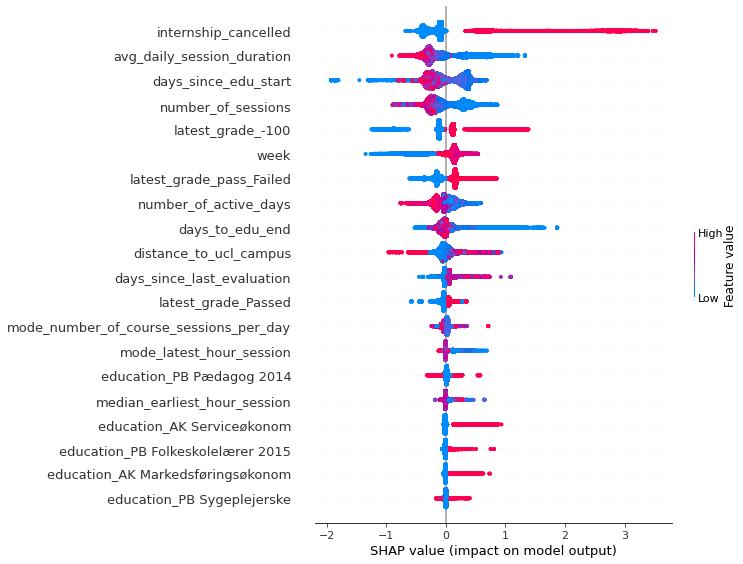

In [16]:
shap.summary_plot(shap_values, data_test.iloc[:,:-4])

## Forudser vi nogle dropouts som ikke har fået aflyst deres praktik?

In [18]:
internship_dropout = data_test[data_test['logits']>0.5].groupby(["internship_cancelled", "group"]).max() 
print("Antal predicted dropouts som har fået aflyst praktik:", internship_dropout.loc[0].shape[0])
print("Antal predicted dropouts som IKKE har aflyst praktik:", internship_dropout.loc[1].shape[1])

Antal predicted dropouts som har fået aflyst praktik: 26
Antal predicted dropouts som IKKE har aflyst praktik: 87


In [19]:
internship_dropout

address_changes  \
internship_cancelled group                                                   
0                    090D3A71-B86D-EB11-A2FB-005056B296A0                0   
                     0FB93E03-AAE0-EB11-A2E9-005056B28D65                0   
                     220A3A71-B86D-EB11-A2FB-005056B296A0                0   
                     2C013A71-B86D-EB11-A2FB-005056B296A0                0   
                     2E1A3935-560A-EC11-A2F1-005056B28D65                0   
...                                                                    ...   
1                    FDB0D666-1FF9-EB11-A2DB-005056B2F3EA                0   
                     FE0A0A71-B86D-EB11-A2FA-005056B24458                0   
                     FEABB472-67FB-EB11-A2DB-005056B2F3EA                0   
                     FF9F0D0C-6FFB-EB11-A2D5-005056B27D6C                0   
                     FFCED30C-88E0-EB11-A2D8-005056B2F3EA                0   

                                                           days_since_last_evaluation  \
internship_cancelled group                                                              
0                    090D3A71-B86D-EB11-A2FB-005056B296A0                        53.0   
                     0FB93E03-AAE0-EB11-A2E9-005056B28D65                        87.0   
                     220A3A71-B86D-EB11-A2FB-005056B296A0                        14.0   
                     2C013A71-B86D-EB11-A2FB-005056B296A0                        48.0   
                     2E1A3935-560A-EC11-A2F1-005056B28D65                         7.0   
...                                                                               ...   
1                    FDB0D666-1FF9-EB11-A2DB-005056B2F3EA                       132.0   
                     FE0A0A71-B86D-EB11-A2FA-005056B24458                      -100.0   
                     FEABB472-67FB-EB11-A2DB-005056B2F3EA                        14.0   
                     FF9F0D0C-6FFB-EB11-A2D5-005056B27D6C                      -100.0   
                     FFCED30C-88E0-EB11-A2D8-005056B2F3EA                      -100.0   

                                                           number_of_evaluations  \
internship_cancelled group                                                         
0                    090D3A71-B86D-EB11-A2FB-005056B296A0                      1   
                     0FB93E03-AAE0-EB11-A2E9-005056B28D65                      0   
                     220A3A71-B86D-EB11-A2FB-005056B296A0                      1   
                     2C013A71-B86D-EB11-A2FB-005056B296A0                      0   
                     2E1A3935-560A-EC11-A2F1-005056B28D65                      1   
...                                                                          ...   
1                    FDB0D666-1FF9-EB11-A2DB-005056B2F3EA                      0   
                     FE0A0A71-B86D-EB11-A2FA-005056B24458                      0   
                     FEABB472-67FB-EB11-A2DB-005056B2F3EA                      1   
                     FF9F0D0C-6FFB-EB11-A2D5-005056B27D6C                      0   
                     FFCED30C-88E0-EB11-A2D8-005056B2F3EA                      0   

                                                           days_since_edu_start  \
internship_cancelled group                                                        
0                    090D3A71-B86D-EB11-A2FB-005056B296A0                   253   
                     0FB93E03-AAE0-EB11-A2E9-005056B28D65                   111   
                     220A3A71-B86D-EB11-A2FB-005056B296A0                   212   
                     2C013A71-B86D-EB11-A2FB-005056B296A0                   197   
                     2E1A3935-560A-EC11-A2F1-005056B28D65                    15   
...                                                                         ...   
1                    FDB0D666-1FF9-EB11-A2DB-005056B2F3EA                   152   
                     FE0A0A71-B86D-EB11-A2FA-0

In [20]:
fig = make_risk_profile_fig(["090D3A71-B86D-EB11-A2FB-005056B296A0",
                             "0FB93E03-AAE0-EB11-A2E9-005056B28D65", 
                             "220A3A71-B86D-EB11-A2FB-005056B296A0"], data_test)
fig.update_layout(width = 1000)

fig.show()

In [21]:
idx_before, idx_after = get_edge_indices("0FB93E03-AAE0-EB11-A2E9-005056B28D65", data_test)
print(idx_before, idx_after)
shap.force_plot(explainer.expected_value, shap_values[idx_before,:], data_test.iloc[idx_before,:-4], link = "logit")


138160 63918


In [22]:
shap.force_plot(explainer.expected_value, shap_values[idx_after,:], data_test.iloc[idx_after,:-4], link = "logit")

In [23]:
idx_before, idx_after = get_edge_indices("0FB93E03-AAE0-EB11-A2E9-005056B28D65", data_test, threshold=0.6)
print(idx_before, idx_after)
shap.force_plot(explainer.expected_value, shap_values[idx_before,:], data_test.iloc[idx_before,:-4], link = "logit")


138160 139245


In [24]:
shap.force_plot(explainer.expected_value, shap_values[idx_after,:], data_test.iloc[idx_after,:-4], link = "logit")